## Image sample (DDPM - guided diffusion - Diffusion beats gans)

In [3]:
# from __future__ import print_function 
import argparse
import os, sys, glob

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1, 2, 3"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import datetime
import pytorch_lightning as pl
from collections import namedtuple
sys.path.insert(0, '../')
from config.base_config import parse_args
from guided_diffusion.script_util import (
    create_img_and_diffusion,
    seed_all,
)

In [4]:
# Config file
def get_cfg(cfg_name):
    cfg_file_path = glob.glob("../config/*/*", recursive=True)
    cfg_file_path = [cfg_path for cfg_path in cfg_file_path if f"/{cfg_name}" in cfg_path]    # Add /{}/ to achieve a case-sensitive of folder
    assert len(cfg_file_path) <= 1
    cfg_file = cfg_file_path[0]
    cfg = parse_args(ipynb={'mode':True, 'cfg':cfg_file})
    return cfg

# Log & Checkpoint file 
def get_model_path(log_dir):
    model_logs_path = glob.glob(f"{sshfs_mount_path}/*/*/", recursive=True) + glob.glob(f"{sshfs_path}/*/*/", recursive=True)
    model_path = [m_log for m_log in model_logs_path if f"/{log_dir}/" in m_log]    # Add /{}/ to achieve a case-sensitive of folder
    assert len(model_path) <= 1
    return model_path[0]


# Settings 

# List model_logs
sshfs_path = "/data/mint/model_logs/"
sshfs_mount_path = "/data/mint/model_logs_mount/"
cfg_name = "cond_img64_by_deca_arcface.yaml"
log_dir = "img64_cond_by_deca_arcface"
# cfg_name = "imgsize_64_condition.yaml"
# log_dir = "imgsize_64_condition"
m_path = get_model_path(log_dir)
cfg = get_cfg(cfg_name)
step = "600000"
set_ = "valid"
name = cfg.img_model.name
ckpt_selector = "ema"

if ckpt_selector == "ema":
    ckpt = f"ema_0.9999_{step}"
elif ckpt_selector == "model":
    ckpt = f"model{step}"
else: raise NotImplementedError

print(glob.glob(f"{m_path}/*.pt"))
img_model_path = f"{m_path}/{name}_{ckpt}.pt"
img_model, diffusion = create_img_and_diffusion(cfg)
img_model.load_state_dict(
    th.load(img_model_path, map_location="cpu")
)
img_model.to('cuda')
img_model.eval()


Merging with :  Namespace(cfg='../config/Various_condition_on_Image/cond_img64_by_deca_arcface.yaml')

['/data/mint/model_logs_mount/v10/img64_cond_by_deca_arcface/opt600000.pt', '/data/mint/model_logs_mount/v10/img64_cond_by_deca_arcface/opt150000.pt', '/data/mint/model_logs_mount/v10/img64_cond_by_deca_arcface/opt400000.pt', '/data/mint/model_logs_mount/v10/img64_cond_by_deca_arcface/ImgCond_ema_0.9999_500000.pt', '/data/mint/model_logs_mount/v10/img64_cond_by_deca_arcface/opt000000.pt', '/data/mint/model_logs_mount/v10/img64_cond_by_deca_arcface/ImgCond_model500000.pt', '/data/mint/model_logs_mount/v10/img64_cond_by_deca_arcface/ImgCond_model600000.pt', '/data/mint/model_logs_mount/v10/img64_cond_by_deca_arcface/ImgCond_ema_0.9999_200000.pt', '/data/mint/model_logs_mount/v10/img64_cond_by_deca_arcface/opt550000.pt', '/data/mint/model_logs_mount/v10/img64_cond_by_deca_arcface/opt350000.pt', '/data/mint/model_logs_mount/v10/img64_cond_by_deca_arcface/opt450000.pt', '/data/mint/model_l

UNetModelCondition(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequentialCond(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequentialCond(
      (0): ResBlockCondition(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (cond_proj_layers): Sequential(
          (0): Linear(in_features=698, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
          (3): SiLU()
          (4): Linear(in_features=512, out_features=128, bias=True)
          (5): SiLU()
        )
        (h_upd): Identity()
        (x_upd): Identity()
     

In [5]:
from guided_diffusion.dataloader.img_util import decolor

def plot_sample(img, **kwargs):
    columns = 6
    rows = 15
    fig = plt.figure(figsize=(20, 20), dpi=100)
    img = img.permute(0, 2, 3, 1) # BxHxWxC
    pt = 0
    for i in range(0, img.shape[0]):
        s_ = decolor(s=img[i], out_c='rgb')
        s_ = s_.detach().cpu().numpy()
        fig.add_subplot(rows, columns, pt+1)
        plt.imshow(s_)
        pt += 1

        if kwargs is not None:
            # Plot other images
            for k in kwargs:
                fig.add_subplot(rows, columns, pt+1)
                s_ = decolor(s=kwargs[k][i].permute(1, 2, 0), out_c='rgb')
                s_ = s_.detach().cpu().numpy()
                plt.imshow(s_)
                pt += 1
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.65, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.2)
    plt.show()

def plot_deca(sample):

    img_ = []
    from tqdm.auto import tqdm
    for i in tqdm(range(sample['deca_output'].shape[0])):
        deca_params = sample['deca_output'][i].clone()
        deca_params = denormalize(deca_params, min_val=th.tensor(min_value_train).cuda(), max_val=th.tensor(max_value_train).cuda(), a=-cfg.param_model.bound, b=cfg.param_model.bound).float()
        shape = deca_params[None, :100]
        pose = deca_params[None, 100:106]
        exp = deca_params[None, 106:156]
        cam = deca_params[None, 156:]
        img = params_to_model(shape=shape, exp=exp, pose=pose, cam=cam, i=i)
        img_.append(img["shape_images"])

    plot_sample(th.cat(img_, dim=0))
    return th.cat(img_, dim=0)
        

In [6]:
from ast import Expression, arg, parse
from pickle import PickleError
import argparse
import numpy as np
import pandas as pd
import torch as th
import torch.nn.functional as F
import glob, os
import PIL
import matplotlib.pyplot as plt
from model_3d.FLAME import FLAME
from model_3d.FLAME.config import cfg as flame_cfg
from collections import defaultdict
from model_3d.FLAME.utils.renderer import SRenderY
import model_3d.FLAME.utils.util as util
import model_3d.FLAME.utils.detectors as detectors
from skimage.io import imread, imsave
from skimage.transform import estimate_transform, warp, resize, rescale

flame = FLAME.FLAME(flame_cfg.model).cuda()

def params_to_model(shape, exp, pose, cam, i, uvdn=None):
    verts, landmarks2d, landmarks3d = flame(shape_params=shape, 
            expression_params=exp, 
            pose_params=pose)
    renderer = SRenderY(image_size=256, obj_filename=flame_cfg.model.topology_path, uv_size=flame_cfg.model.uv_size).cuda()

    ## projection
    landmarks2d = util.batch_orth_proj(landmarks2d, cam)[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:]#; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2
    landmarks3d = util.batch_orth_proj(landmarks3d, cam); landmarks3d[:,:,1:] = -landmarks3d[:,:,1:] #; landmarks3d = landmarks3d*self.image_size/2 + self.image_size/2
    trans_verts = util.batch_orth_proj(verts, cam); trans_verts[:,:,1:] = -trans_verts[:,:,1:]

    ## rendering
    shape_images = renderer.render_shape(verts, trans_verts)

    opdict = {'verts' : verts,}

    os.makedirs('./rendered_obj', exist_ok=True)
    save_obj(renderer=renderer, filename=(f'./rendered_obj/{i}.obj'), opdict=opdict)
    
    return {"shape_images":shape_images, "landmarks2d":landmarks2d, "landmarks3d":landmarks3d}

def save_obj(renderer, filename, opdict):
    '''
    vertices: [nv, 3], tensor
    texture: [3, h, w], tensor
    '''
    i = 0
    vertices = opdict['verts'][i].cpu().numpy()
    faces = renderer.faces[0].cpu().numpy()
    colors = np.ones(shape=vertices.shape) * 127.5

    # save coarse mesh
    util.write_obj(filename, vertices, faces, colors=colors)

def read_params(path):
    params = pd.read_csv(path, header=None, sep=" ", index_col=False, lineterminator='\n')
    params.rename(columns={0:'img_name'}, inplace=True)
    params = params.set_index('img_name').T.to_dict('list')
    return params

def swap_key(params):
    params_s = defaultdict(dict)
    for params_name, v in params.items():
        for img_name, params_value in v.items():
            params_s[img_name][params_name] = np.array(params_value).astype(np.float64)

    return params_s

def normalize(arr, min_val=None, max_val=None, a=-1, b=1):
    '''
    Normalize any vars to [a, b]
    :param a: new minimum value
    :param b: new maximum value
    :param arr: np.array shape=(N, #params_dim) e.g. deca's params_dim = 159
    ref : https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
    '''
    if max_val is None and min_val is None:
        max_val = np.max(arr, axis=0)    
        min_val = np.min(arr, axis=0)

    arr_norm = ((b-a) * (arr - min_val) / (max_val - min_val)) + a
    return arr_norm, min_val, max_val

def denormalize(arr_norm, min_val, max_val, a=-1, b=1):
    arr_denorm = (((arr_norm - a) * (max_val - min_val)) / (b - a)) + min_val
    return arr_denorm

def load_params(path, params_key):

    anno_path = glob.glob(f'{path}/*.txt')
    params = {}
    for k in params_key:
        for p in anno_path:
            # Params
            if k in p:
                print(f'Key=> {k} : Filename=>{p}')
                params[k] = read_params(path=p)

    params_s = swap_key(params)

    all_params = []
    for img_name in params_s:
        each_img = []
        for k in params_key:
            each_img.append(params_s[img_name][k])
        all_params.append(np.concatenate(each_img))
    all_params = np.stack(all_params)

    return params_s, all_params

# Load params
params_key = ['shape', 'pose', 'exp', 'cam', 'light', 'faceemb']
params_train, params_train_arr = load_params(path="/data/mint/ffhq_256_with_anno/params/train/", params_key=params_key)
_, min_value_train, max_value_train = normalize(a=-cfg.param_model.bound, b=cfg.param_model.bound, arr=params_train_arr.copy())

params_valid, params_valid_arr = load_params(path="/data/mint/ffhq_256_with_anno/params/valid/", params_key=params_key)
_, min_value_valid, max_value_valid = normalize(a=-cfg.param_model.bound, b=cfg.param_model.bound, arr=params_valid_arr.copy())


creating the FLAME Decoder
Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-light-anno.txt
Key=> faceemb : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-faceemb-anno.txt
Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/param

In [7]:
# Load image for condition (if needed)
import blobfile as bf
import random
from guided_diffusion.dataloader.img_util import (
    random_crop_arr,
    center_crop_arr,
    resize_arr
)

def _list_image_files_recursively(data_dir):
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(_list_image_files_recursively(full_path))
    return results

def augmentation(pil_image):
        # Resize image by resizing/cropping to match the resolution
        if cfg.img_model.resize_mode == 'random_crop':
            arr = random_crop_arr(pil_image, cfg.img_model.image_size)
        elif cfg.img_model.resize_mode == 'center_crop':
            arr = center_crop_arr(pil_image, cfg.img_model.image_size)
        elif cfg.img_model.resize_mode == 'resize':
            arr = resize_arr(pil_image, cfg.img_model.image_size)
        else: raise NotImplemented

        return arr

path = f"/data/mint/ffhq_256_with_anno/ffhq_256/{set_}"
all_files = _list_image_files_recursively(path)

def load_img_condition(n=10, vis=False):
    imgs = []
    for path in all_files[:n]:
        with bf.BlobFile(path, "rb") as f:
            pil_image = PIL.Image.open(f)
            pil_image.load()
            pil_image = pil_image.convert("RGB")

            raw_img = augmentation(pil_image=pil_image)

            raw_img = (raw_img / 127.5) - 1

        imgs.append(np.transpose(raw_img, (2, 0, 1)))
    imgs = np.stack(imgs)
    if vis:
        plot_sample(th.tensor(imgs))
    return {'image':th.tensor(imgs).cuda()}

def load_deca_condition(params, n=10, r_idx=None):
    '''
    Load deca condition and stack all of thems into 1D-vector
    '''
    if r_idx is None:
        r_idx = list(np.random.choice(a=np.arange(0, len(params)), size=n, replace=False))
    img_name = [list(params.keys())[i] for i in r_idx]

    all = []

    # Choose only param in params_selector
    params_selector = cfg.param_model.params_selector
    for name in img_name:
        each_param = [params[name][p_name] for p_name in params_selector]
        all.append(np.concatenate(each_param))

    all = np.stack(all, axis=0)        
    return {'cond_params':th.tensor(all).cuda(), 'image_name':img_name, 'r_idx':r_idx}

class PLInference(pl.LightningModule):
    def __init__(self, img_model, sample_fn):
        super(PLInference, self).__init__()
        self.img_model = img_model
        self.sample_fn = sample_fn

    def forward(self, model_kwargs, noise):
        # seed_all(33)
        sample = self.sample_fn(
            model=self.img_model,
            shape=noise.shape,
            noise=noise,
            clip_denoised=cfg.diffusion.clip_denoised,
            model_kwargs=model_kwargs
        )
        return {"img_output":sample}

def cond_params_location():
    '''
    Return the idx [i, j] for vector[i:j] that the given parameter is located.
    e.g. shape is 1-50, etc.

    :param p: p in ['shape', 'pose', 'exp', ...]
    '''
    params_dict = {'shape':100, 'pose':6, 'exp':50, 'cam':3, 'light':27, 'faceemb':512,}
    params_selected_loc = {}
    params_ptr = 0
    for param in cfg.param_model.params_selector:
        params_selected_loc[param] = [params_ptr, params_ptr + params_dict[param]]
        params_ptr += params_dict[param]
    return params_selected_loc
    

def get_cond_params(batch_size, mode, interchange=None, r_idx=None, base_idx=0, model_kwargs=None):
    '''
    Return the condition parameters used to condition the network.
    :params mode: 
    '''
    assert base_idx < batch_size
    if model_kwargs is None:
        model_kwargs = {}
        model_kwargs.update(load_deca_condition(n=batch_size, params=params_train if set_ == 'train' else params_valid, r_idx=r_idx))
    if mode == 'fixed_cond':
        cond_params = th.stack([model_kwargs['cond_params'][model_kwargs['r_idx'][base_idx]]]*batch_size, dim=0)
        image_name = [model_kwargs['image_name'][base_idx]] * batch_size
    elif mode == 'vary_cond':
        cond_params = model_kwargs['cond_params']
        image_name = model_kwargs['image_name']

    else: raise NotImplementedError
        
    if interchange is not None:
        # Fixed the first image
        params_selector = cfg.param_model.params_selector
        params_selected_loc = cond_params_location()
        cond_params_itc = cond_params[[base_idx]].clone().repeat(batch_size, 1)
        for itc in interchange:
            assert itc in params_selector
            i, j = params_selected_loc[itc]
            cond_params_itc[1:, i:j] = cond_params[1:, i:j]

        cond_params = cond_params_itc

    return {'cond_params':cond_params, 'image_name':image_name}

def get_init_noise(batch_size, mode, img_size):
    '''
    Return the init_noise used as input.
    :params mode: mode for sampling noise => 'vary_noise', 'fixed_noise'
    '''
    if mode == 'vary_noise':
        init_noise = th.randn((batch_size, 3, img_size, img_size)).cuda()
    elif mode == 'fixed_noise':
        init_noise = th.cat([th.randn((1, 3, img_size, img_size)).cuda()] * batch_size, dim=0)
    else: raise NotImplementedError

    return init_noise

def prep_model_input(batch_size, mode, interchange, r_idx=None, base_idx=0):
    '''
    Prepare model input e.g. noise, condition, etc.
    :params batch_size:  
    :params mode: Dict of fixed/vary noise and condition mode
    :params interchange: List of interchange parameters between images by fixed the first image as a base parameters 
        e.g. ['pose', 'exp'] => use cond[0] as base condition and change only 'pose' and 'exp' following other images in batch
    :params r_idx:
    :params base_idx: 
    '''

    img_size = cfg.img_model.image_size
    init_noise = get_init_noise(batch_size=batch_size, mode=mode['init_noise'], img_size=img_size)
    model_kwargs = get_cond_params(batch_size=batch_size, mode=mode['cond_params'], interchange=interchange, r_idx=r_idx, base_idx=base_idx)
    return init_noise, model_kwargs


In [8]:
batch_size = 20
base_idx = 4
mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}
interchange=['light']
seed_all(47)
init_noise, model_kwargs = prep_model_input(batch_size=batch_size, mode=mode, interchange=interchange, base_idx=base_idx)

pl_inference = PLInference(img_model=img_model, sample_fn=diffusion.ddim_sample_loop)
sample_ddim = pl_inference(noise=init_noise, model_kwargs=model_kwargs)
plot_sample(img=sample_ddim['img_output'])


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
batch_size = 20
settings = {'mode':[{'init_noise':'fixed_noise', 'cond_params':'vary_cond'}], 'seed':[47], 'interchange':[['faceemb'], ['pose'], ['shape', 'pose'], ['exp', 'shape'], ['exp', 'pose'], ['shape', 'exp', 'pose'], ['pose', 'faceemb'], ['shape', 'pose', 'faceemb'], ['exp', 'shape', 'faceemb'], ['exp', 'pose', 'faceemb'], ['shape', 'exp', 'pose', 'faceemb'], ['shape', 'faceemb'], ['exp', 'faceemb']]}

for m in settings['mode']:
    for s in settings['seed']:
        for itc in settings['interchange']:
            seed_all(s)
            base_idx = 4
            interchange=itc
            init_noise, model_kwargs = prep_model_input(batch_size=batch_size, mode=m, interchange=itc, base_idx=base_idx)
            pl_inference = PLInference(img_model=img_model, sample_fn=diffusion.ddim_sample_loop)#p_sample_loop)
            sample_ddim = pl_inference(noise=init_noise, model_kwargs=model_kwargs)
            print(f"{m}-{s}-{itc}")
            plot_sample(img=sample_ddim['img_output'])
            plot_sample(img=src_img, render_img=render_img, sampling_img=sample_ddim['img_output'])

# Visualization of Conditioned for each of sampling image

In [ ]:
img_dataset_path = f'/data/mint/ffhq_256_with_anno/ffhq_256/{set_}/'
if cfg.img_model.conditioning:
    print("Use conditioning")
    img_name_list = model_kwargs['image_name']
    # img_name_list = [model_kwargs['image_name'][7]] *batch_size
else:
    img_name_list = [str(n) + '.jpg' for n in list(np.random.randint(0, 60000, 10))]

if set_ == 'valid':
    params = params_valid
elif set_ == 'train':
    params = params_train
else: raise NotImplementedError

render_img_list = []
src_img_list = []
img_list = []
for img_name in img_name_list:
    shape = th.tensor(params[img_name]['shape'][None, :]).float().cuda()
    pose = th.tensor(params[img_name]['pose'][None, :]).float().cuda()
    exp = th.tensor(params[img_name]['exp'][None, :]).float().cuda()
    cam = th.tensor(params[img_name]['cam'][None, :]).float().cuda()

    src_img = PIL.Image.open(img_dataset_path + img_name).resize((cfg.img_model.image_size, cfg.img_model.image_size))
    src_img = (th.tensor(np.transpose(src_img, (2, 0, 1)))[None, :] / 127.5) - 1
    src_img_list.append(src_img)

    render_img = params_to_model(shape=shape, exp=exp, pose=pose, cam=cam, i=img_name)
    render_img_list.append(render_img["shape_images"])

src_img = th.cat(src_img_list, dim=0)
render_img = th.cat(render_img_list, dim=0)
plot_sample(img=src_img, render_img=render_img, sampling_img=sample_ddim['img_output'])

Open&Resize images: 21it [00:00, 302.07it/s]
Generate Face Embedding: 1it [00:00,  2.93it/s]


creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/deca/data/deca_model.tar


  0%|          | 0/21 [00:00<?, ?it/s]

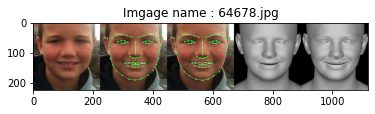

  5%|▍         | 1/21 [00:03<01:04,  3.24s/it]

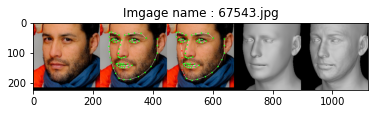

 10%|▉         | 2/21 [00:03<00:27,  1.46s/it]

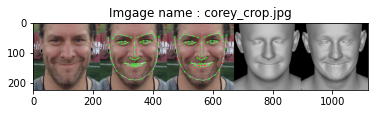

 14%|█▍        | 3/21 [00:04<00:22,  1.28s/it]

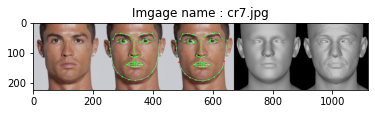

 19%|█▉        | 4/21 [00:06<00:27,  1.63s/it]

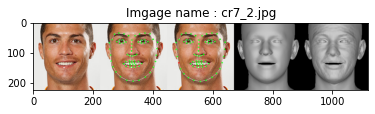

 24%|██▍       | 5/21 [00:07<00:21,  1.35s/it]

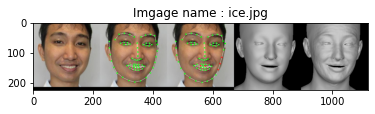

 29%|██▊       | 6/21 [00:08<00:18,  1.23s/it]

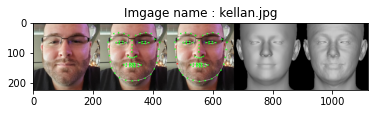

 33%|███▎      | 7/21 [00:08<00:12,  1.12it/s]

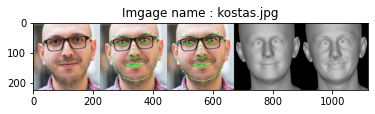

 38%|███▊      | 8/21 [00:09<00:11,  1.17it/s]

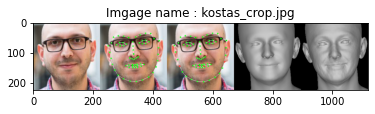

 43%|████▎     | 9/21 [00:10<00:08,  1.34it/s]

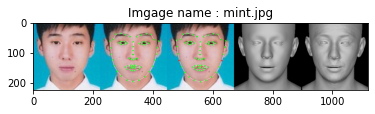

 48%|████▊     | 10/21 [00:10<00:08,  1.33it/s]

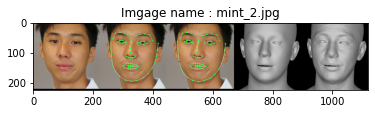

 52%|█████▏    | 11/21 [00:11<00:08,  1.22it/s]

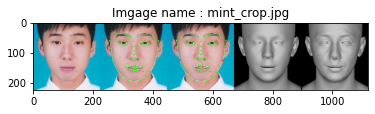

 57%|█████▋    | 12/21 [00:12<00:07,  1.21it/s]

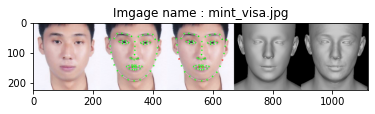

 62%|██████▏   | 13/21 [00:13<00:06,  1.25it/s]

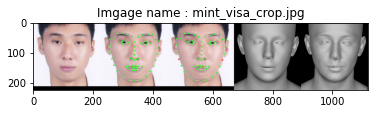

 67%|██████▋   | 14/21 [00:14<00:05,  1.28it/s]

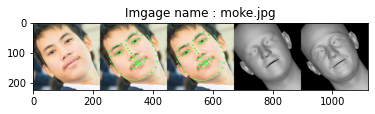

 71%|███████▏  | 15/21 [00:14<00:04,  1.35it/s]

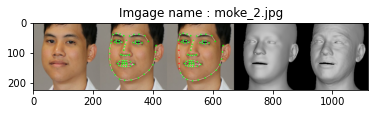

 76%|███████▌  | 16/21 [00:15<00:03,  1.25it/s]

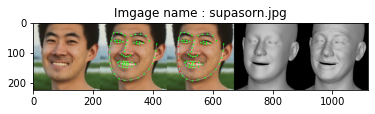

 81%|████████  | 17/21 [00:15<00:02,  1.61it/s]

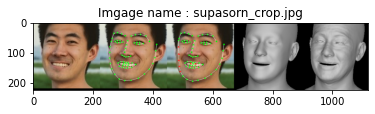

 86%|████████▌ | 18/21 [00:16<00:01,  1.77it/s]

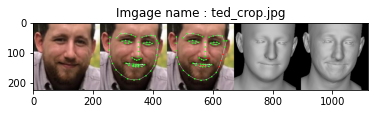

 90%|█████████ | 19/21 [00:17<00:01,  1.61it/s]

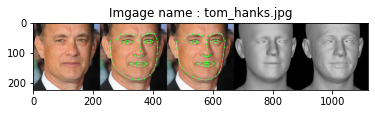

 95%|█████████▌| 20/21 [00:17<00:00,  1.58it/s]

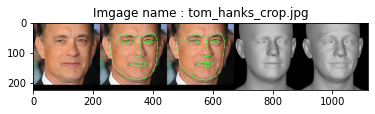

100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


In [13]:
# In-the-wild Image
import torch as th
import sys, os

sys.path.insert(0, './cond_utils/arcface/')
sys.path.insert(0, './cond_utils/deca/')
from cond_utils.arcface import get_arcface_emb
from cond_utils.deca import get_deca_emb
itw_path = "./itw_images/"
device = 'cuda:3'

# ArcFace
faceemb_itw, emb = get_arcface_emb.get_arcface_emb(img_path=itw_path, device=device)

# DECA
params_dict = {'shape':100, 'pose':6, 'exp':50, 'cam':3, 'light':27, 'faceemb':512,}
deca_itw = get_deca_emb.get_deca_emb(img_path=itw_path, device=device)

assert deca_itw.keys() == faceemb_itw.keys()
params_itw = {}
for img_name in deca_itw.keys():
    params_itw[img_name] = deca_itw[img_name]
    params_itw[img_name].update(faceemb_itw[img_name])

In [ ]:
itw_kwargs = {}
itw_kwargs = load_deca_condition(params=params_itw, n=len(params_itw.keys()), r_idx=[12, 5, 14, 0, 10, 13, 1, 17, 4, 20, 11, 15, 6, 9, 16, 3, 19, 7, 2, 18, 8])
src_img_list = []
for img_name in itw_kwargs['image_name']:
    src_img = PIL.Image.open(itw_path + img_name).resize((cfg.img_model.image_size, cfg.img_model.image_size))
    src_img = (th.tensor(np.transpose(src_img, (2, 0, 1)))[None, :] / 127.5) - 1
    src_img_list.append(src_img)

src_img = th.cat(src_img_list, dim=0)

In [ ]:
# seed_all(47)

pl_inference = PLInference(img_model=img_model, sample_fn=diffusion.ddim_sample_loop)#p_sample_loop)
img_size = cfg.img_model.image_size
mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}
itw_noise = get_init_noise(batch_size=len(params_itw.keys()), mode=mode['init_noise'], img_size=img_size)
sample_ddim = pl_inference(noise=itw_noise, model_kwargs=itw_kwargs)
plot_sample(img=src_img, sampling_img=sample_ddim['img_output'])

pl_inference = PLInference(img_model=img_model, sample_fn=diffusion.p_sample_loop)
img_size = cfg.img_model.image_size
mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}
itw_noise = get_init_noise(batch_size=len(params_itw.keys()), mode=mode['init_noise'], img_size=img_size)
sample_p = pl_inference(noise=itw_noise, model_kwargs=itw_kwargs)
plot_sample(img=src_img, sampling_img=sample_p['img_output'],)

# DDIM Inversion

In [11]:
def resize_arr(pil_image, image_size):
    img = pil_image.resize((image_size, image_size), PIL.Image.ANTIALIAS)
    return np.array(img)

def prep_images(path):
    with bf.BlobFile(path, "rb") as f:
        pil_image = PIL.Image.open(f)
        pil_image.load()
    pil_image = pil_image.convert("RGB")

    raw_img = resize_arr(pil_image=pil_image, image_size=cfg.img_model.image_size)
    raw_img = (raw_img / 127.5) - 1

    return np.transpose(raw_img, [2, 0, 1])

class PLReverseSampling(pl.LightningModule):
    def __init__(self, img_model, sample_fn, device):
        super(PLReverseSampling, self).__init__()
        self.sample_fn = sample_fn
        self.img_model = img_model.to(device)

    def forward(self, x, model_kwargs, progress=True):
        # Mimic the ddim_sample_loop or p_sample_loop
        # seed_all(33)

        if self.sample_fn == diffusion.ddim_reverse_sample_loop:
            sample = self.sample_fn(
                model=self.img_model,
                x=x,
                clip_denoised=True,
                model_kwargs=model_kwargs,
                progress=progress
            )
        elif self.sample_fn == diffusion.q_sample:
            sample = self.sample_fn(
                x_start=x,
                t = 999
            )
        elif self.sample_fn == diffusion.ddim_reverse_sample:
            sample = self.sample_fn(
                model=self.img_model,
                x=x,
                t = th.tensor(np.stack([999] * x.shape[0], axis=0)).cuda(),
                model_kwargs=model_kwargs
            )
        else: raise NotImplementedError

        return {"img_output":sample}

class PLSampling(pl.LightningModule):
    def __init__(self, img_model, sample_fn):
        super(PLSampling, self).__init__()
        self.img_model = img_model
        self.sample_fn = sample_fn

    def forward(self, model_kwargs, noise):
        # seed_all(33)
        sample = self.sample_fn(
            model=self.img_model,
            shape=noise.shape,
            noise=noise,
            clip_denoised=cfg.diffusion.clip_denoised,
            model_kwargs=model_kwargs
        )
        return {"img_output":sample}


In [14]:
itw_path = "./itw_images/"
device = 'cuda:0'
base_idx = 10
all_itw_files = _list_image_files_recursively(itw_path)
r_idx = range(len(all_itw_files))
itw_images = th.tensor(np.stack([prep_images(all_itw_files[i]) for i in range(len(all_itw_files))], axis=0)).to(device)
itw_kwargs = {}
itw_kwargs = load_deca_condition(params=params_itw, n=len(params_itw.keys()), r_idx=r_idx)

itw_kwargs['cond_params'] = itw_kwargs['cond_params'].to(device)
pl_reverse_sampling = PLReverseSampling(img_model=img_model, sample_fn=diffusion.ddim_reverse_sample, device=device)
# pl_reverse_sampling = PLReverseSampling(img_model=img_model, sample_fn=diffusion.ddim_reverse_sample_loop, device=device)
# pl_reverse_sampling = PLReverseSampling(img_model=img_model, sample_fn=diffusion.q_sample, device=device)
img_size = cfg.img_model.image_size
reverse_ddim_sample = pl_reverse_sampling(x=itw_images, model_kwargs=itw_kwargs, progress=True)

pl_sampling = PLSampling(img_model=img_model, sample_fn=diffusion.ddim_sample_loop)
sample_ddim = pl_sampling(noise=reverse_ddim_sample['img_output'], model_kwargs=itw_kwargs)
plot_sample(img=itw_images, reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])


interchange = ['pose']
mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}
# Interchange the condition
itw_kwargs = get_cond_params(batch_size=len(r_idx), mode=mode['cond_params'], interchange=interchange, r_idx=r_idx, base_idx=base_idx, model_kwargs=itw_kwargs)
pl_sampling = PLSampling(img_model=img_model, sample_fn=diffusion.ddim_sample_loop)
sample_ddim = pl_sampling(noise=th.cat([reverse_ddim_sample['img_output'][[base_idx]]] * len(r_idx), dim=0), model_kwargs=itw_kwargs)
plot_sample(img=itw_images, reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])



RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 10.76 GiB total capacity; 9.70 GiB already allocated; 31.44 MiB free; 9.76 GiB reserved in total by PyTorch)

# Temporal Consistency

In [2]:
# Load driven video/head poses
def _list_video_files_recursively(data_dir):
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["mp4"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(_list_video_files_recursively(full_path))
    return results

# # In-the-wild Image
import torch as th
import sys, os

import blobfile as bf
sys.path.insert(0, './cond_utils/arcface/')
sys.path.insert(0, './cond_utils/deca/')
from cond_utils.arcface import get_arcface_emb
from cond_utils.deca import get_deca_emb
import cv2

def video2sequence(video_path):
    videofolder = video_path.split('.')[0]
    os.makedirs(videofolder, exist_ok=True)
    video_name = video_path.split('/')[-1].split('.')[0]
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    imagepath_list = []
    while success:
        imagepath = '{}/{}_frame{:04d}.jpg'.format(videofolder, video_name, count)
        cv2.imwrite(imagepath, image)     # save frame as JPEG file
        success,image = vidcap.read()
        count += 1
        imagepath_list.append(imagepath)
    print('video frames are stored in {}'.format(videofolder))
    return imagepath_list

itw_path = "/home/mint/guided-diffusion/sample_scripts/itw_videos/"
itw_path = _list_video_files_recursively(itw_path)
device = 'cuda:3'

for vid in itw_path:
    _ = video2sequence(vid)

video_name = "-7TMJtnhiPM_0000_S1202_E1607_L345_T26_R857_B538" 
img_path = f"/home/mint/guided-diffusion/sample_scripts/itw_videos/cropped_clips/{video_name}/"

params_dict = {'shape':100, 'pose':6, 'exp':50, 'cam':3, 'light':27, 'faceemb':512,}
deca_itw = get_deca_emb.get_deca_emb(img_path=img_path, device='cuda:3', vis=False)

# ArcFace
faceemb_itw, emb = get_arcface_emb.get_arcface_emb(img_path=img_path, device=device)

assert deca_itw.keys() == faceemb_itw.keys()
params_itw = {}
for img_name in deca_itw.keys():
    params_itw[img_name] = deca_itw[img_name]
    params_itw[img_name].update(faceemb_itw[img_name])

video frames are stored in /home/mint/guided-diffusion/sample_scripts/itw_videos/cropped_clips/--Y9imYnfBw_0000_S0_E271_L504_T63_R792_B351
video frames are stored in /home/mint/guided-diffusion/sample_scripts/itw_videos/cropped_clips/--Y9imYnfBw_0000_S1015_E1107_L488_T23_R824_B359
video frames are stored in /home/mint/guided-diffusion/sample_scripts/itw_videos/cropped_clips/-7TMJtnhiPM_0000_S1202_E1607_L345_T26_R857_B538
video frames are stored in /home/mint/guided-diffusion/sample_scripts/itw_videos/cropped_clips/-7TMJtnhiPM_0000_S1608_E1674_L467_T52_R851_B436
creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/deca/data/deca_model.tar


100%|██████████| 406/406 [01:21<00:00,  4.96it/s]
Open&Resize images: 406it [00:03, 134.71it/s]
Generate Face Embedding: 1it [00:01,  1.16s/it]


In [12]:
itw_kwargs = {}
itw_kwargs = load_deca_condition(params=params_itw, n=len(params_itw.keys()), r_idx=range(len(params_itw.keys())))
src_img_list = []
for img_name in itw_kwargs['image_name']:
    src_img = PIL.Image.open(img_path + img_name).resize((cfg.img_model.image_size, cfg.img_model.image_size))
    src_img = (th.tensor(np.transpose(src_img, (2, 0, 1)))[None, :] / 127.5) - 1
    src_img_list.append(src_img)

src_img = th.cat(src_img_list, dim=0)

In [ ]:
interchange = ['pose']
mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}
base_idx = 
# Interchange the condition
itw_kwargs = get_cond_params(batch_size=len(r_idx), mode=mode['cond_params'], interchange=interchange, r_idx=r_idx, base_idx=base_idx, model_kwargs=itw_kwargs)
pl_sampling = PLSampling(img_model=img_model, sample_fn=diffusion.ddim_sample_loop)
sample_ddim = pl_sampling(noise=th.cat([reverse_ddim_sample['img_output'][[base_idx]]] * len(r_idx), dim=0), model_kwargs=itw_kwargs)
plot_sample(img=itw_images, reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])

In [42]:
# Sequence2video
def sequence2video(img_path, video_name):
    fourcc = cv2.VideoWriter_fourcc('F', 'M', 'P', '4')
    video = cv2.VideoWriter("./gg.avi", fourcc, 1, (cfg.img_model.image_size, cfg.img_model.image_size)) 
  
    import tqdm
    # Appending the images to the video one by one
    for image in tqdm.tqdm(img_path): 
        frame = cv2.imread(image)
        frame = cv2.resize(frame, (cfg.img_model.image_size, cfg.img_model.image_size))
        video.write(frame)
      
    video.release()  # releasing the video generated

img_path = _list_image_files_recursively(data_dir=f"./itw_videos/cropped_clips/{video_name}/")
sequence2video(img_path=img_path, video_name=video_name)

100%|██████████| 406/406 [00:02<00:00, 200.34it/s]
